Based on https://github.com/UNC-optics/Introduction-to-holography/blob/master/Demo_1_Wave_Propagation.m

In [23]:
import numpy as np 
import matplotlib.pyplot as plt
from skimage import io, transform

In [24]:
def get_image(x_axis_size, y_axis_size):
    url = "https://raw.githubusercontent.com/UNC-optics/Introduction-to-holography/master/Image1.jpg"

    data = io.imread( url ).astype( float )
    data = np.mean( data, 2 )

    data = data - np.min( data )
    data = data / np.max( data )
    data = 1. - data

    data = data / np.sum( data )

    data = transform.resize( data, ( x_axis_size, y_axis_size ) )

    return -data

def show_results( Intensity, Amplitude, Phase, z ):
    fig, axs = plt.subplots( 1, 3, figsize=( 9, 5 ), sharey=True, sharex=True )

    axs[ 0 ].imshow( Intensity, cmap='gray' )
    axs[ 0 ].set_xlabel( 'X [mm]' ) 
    axs[ 0 ].set_ylabel( 'Y [mm]' )
    axs[ 0 ].set_title( f'Intensity at z={z}' )

    axs[ 1 ].imshow( Amplitude, cmap='gray' )
    axs[ 1 ].set_xlabel( 'X [mm]' ) 
    axs[ 1 ].set_ylabel( 'Y [mm]' )
    axs[ 1 ].set_title( f'Amplitude at z={z}' ) 

    axs[ 2 ].imshow( Phase, cmap='gray' )
    axs[ 2 ].set_xlabel( 'X [mm]' ) 
    axs[ 2 ].set_ylabel( 'Y [mm]' )
    axs[ 2 ].set_title( f'Phase at z={z}' )  


wavelength = 1.0e-6 # meters (1.0 * 10^-6 = 0.0000010) AKA lambda
pixel_size = 10.0e-6 # meters
x_axis_size = 300
y_axis_size = 300

propagation_distances_meters = np.linspace(0, 0.010, 20) # 20 equally spaced numbers between 0.010 and 20 inclusive
image = get_image(x_axis_size, y_axis_size)

# Create a complex field by setting amplitude and phase
amplitude = -np.sqrt( image, dtype=complex )

# select one of the options below for phase
phase = np.zeros((x_axis_size, y_axis_size))
#phase = 2. * np.pi * np.random.rand( x_axis_size, y_axis_size )

complex_field = amplitude * np.exp(1j * phase) # j = sqrt(-1)

# Fresnel Diffraction

Fresnel diffraction models how a planar light wave hitting an aperture of arbitrary shape diffuses over a screen placed at a distant $z$ from that aperture.
It takes advantage of the Huygens Principle whereby an aperture can be modelled as a number of point sources each emitting a spherical wave. The intensity of the light hitting any point $(x, y, z)$ on the screen is the sum of the contributions from each of these point sources:
\begin{equation}
A(x, y, z) = \frac{e^{izk}}{iz\lambda}\int\int_{-\infty}^{\infty}A(x^{\prime}, y^{\prime}, z) e^{\frac{ik}{2z}[(x-x^{\prime})^2 + (y - y^{\prime})^2]}dx^{\prime}dy^{\prime}
\end{equation}
where $(x^{\prime}, y^{\prime}, 0)$ is a point on the aperture and $k=\frac{2\pi}{\lambda}$ with $\lambda$ being the wave length.  
The following implementation takes advantage of the observation that the above can be expressed in terms of a [convolution](https://en.wikipedia.org/wiki/Convolution) operation.  
Let $G(x, y, z) = e^{\frac{ik}{2z}(x^2 + y^2)}$, then the Fresnel diffraction may be rewritten as:
\begin{equation}
A(x, y, z) = \frac{e^{izk}}{iz\lambda} (A*G)(x, y, z)
\end{equation}
The convolution operation $*$ can be turned into a multiplication by applying the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem) and switching from the spatial domain to the frequency domain through the application of a *Fourier Transform* $\mathcal{F}$ on both $A$ and $G$. Therefore the final expression becomes:
\begin{equation}
A(x, y, z) = \frac{e^{izk}}{iz\lambda} \mathcal{F}^{-1}(\mathcal{F}(A)\cdot\mathcal{F}(G))
\end{equation}
where $\mathcal{F}^{-1}$ is the $inverse$ Fourier Transform required in order to get back to the spatial domain.  
Note that after fully computing the inverse transform, the denominator $iz\lambda$ cancels out leaving only the pure $phase$ term $e^{izk}$ which can be disregarded if all we care about is the field value (i.e. the amplitudes).


In [25]:
def fresnelDiffraction( amplitudes, wavelength, z, psx, psy ):

    M, N = amplitudes.shape

    UY = np.arange( M )
    UY = UY - np.mean( UY )

    UY -= 1 if M%2 == 1 else .5

    UX = np.arange( N )
    UX = UX - np.mean( UX )

    UX -= 1 if N%2 == 1 else .5

    x, y = np.meshgrid( UX, UY )
    
    # in a discrete fourier transform setting
    # the following are the fractional angles 
    # in the complex circle representing each frequency
    kx = x / psx / N 
    ky = y / psy / M 

    H = np.exp( -1j * np.pi * wavelength * z * ( kx**2 + ky**2 ) )

    H = np.fft.fftshift( H )

    objFT = np.fft.fft2( amplitudes )

    field = np.fft.ifft2( objFT * H )

    return field

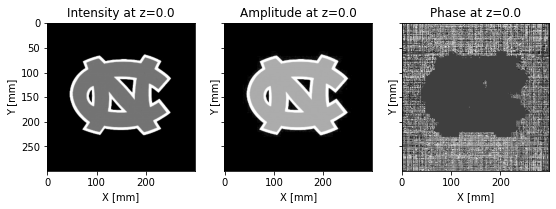

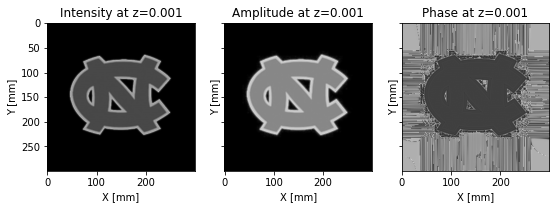

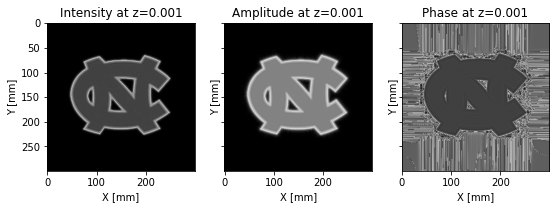

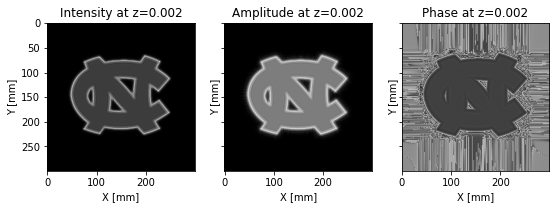

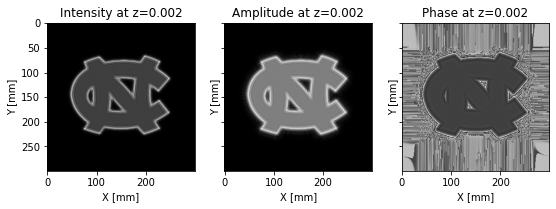

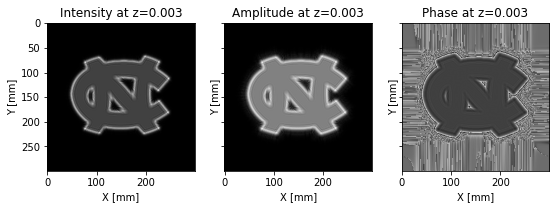

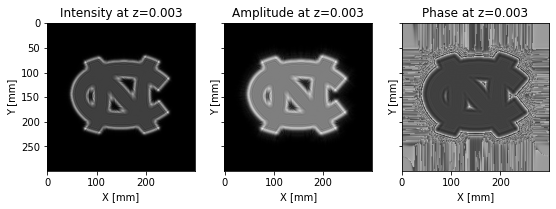

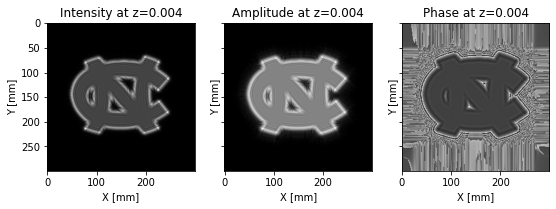

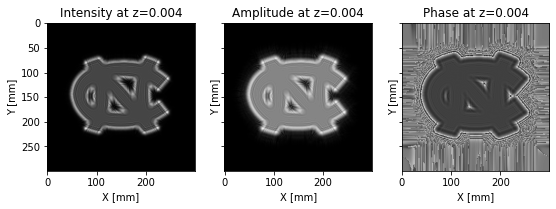

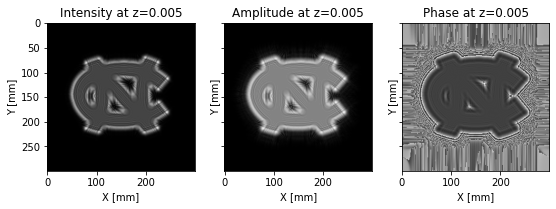

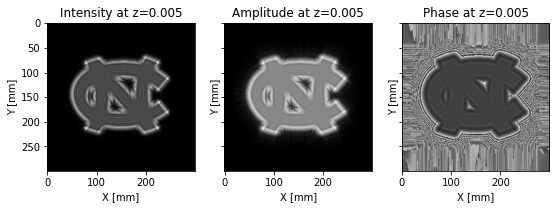

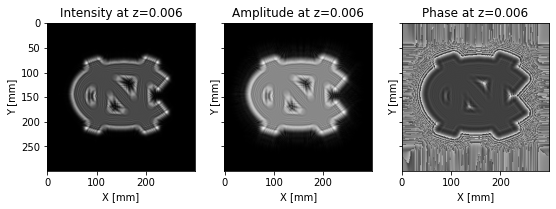

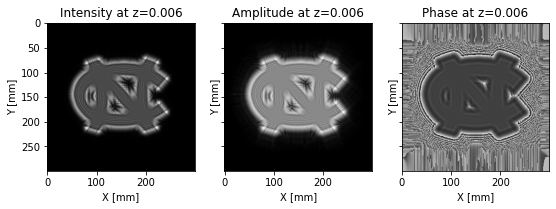

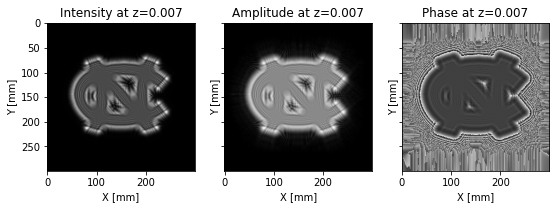

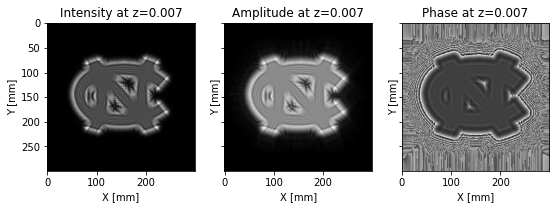

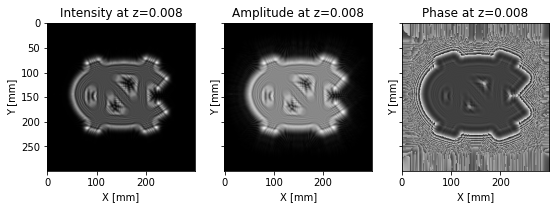

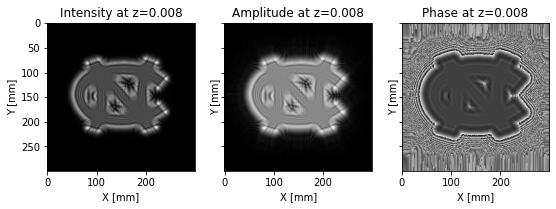

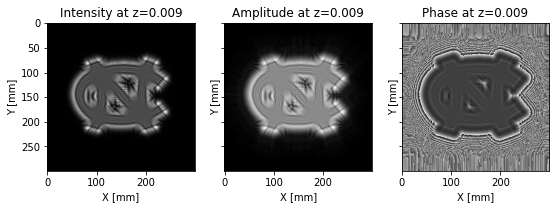

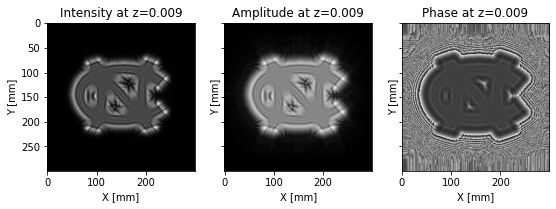

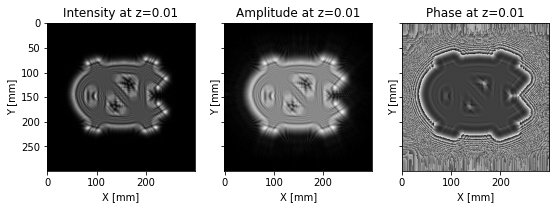

In [26]:
for i in range(propagation_distances_meters.size):
    # Propagate the field
    propagation_distance_meters = propagation_distances_meters[i]
    new_field = fresnelDiffraction(complex_field, wavelength, propagation_distance_meters, pixel_size, pixel_size)

    intensity_at_z = np.abs(new_field)**2
    amplitude_at_z = np.abs(new_field)
    phase_at_z = np.angle(new_field)

    show_results(intensity_at_z, amplitude_at_z, phase_at_z, round( propagation_distance_meters, 3 ) )